## **Objective : Predicting House Prices in Banglore**

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
# matplotlib.rcParams["figure.figsize"] = (20,10)

In [ ]:
import warnings

# Hide all warnings
warnings.filterwarnings('ignore')

### **Data Load : Loading banglore house price data**

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/BengluruHousePrices/bengaluru_house_prices.csv')
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [ ]:
print(df1.shape)
print(df1.columns)


(13320, 9)
Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')


In [ ]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [ ]:
df1['area_type'].value_counts()

,count
area_type,
Super built-up Area,8790
Built-up Area,2418
Plot Area,2025
Carpet Area,87


In [ ]:
# df1.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


**Dropping features that are not required to build our model**

In [ ]:
df2 = df1.drop(['area_type', 'availability', 'society', 'balcony'], axis='columns')
df2.shape

(13320, 5)

### **Data Cleaning : Handle NA Values**

In [ ]:
df2.isnull().sum()

,0
location,1
size,16
total_sqft,0
bath,73
price,0


In [ ]:
df3 = df2.dropna()
df3.isnull().sum()

,0
location,0
size,0
total_sqft,0
bath,0
price,0


In [ ]:
df3.shape

(13246, 5)

### **Feature Engineering**

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [ ]:
df3['bhk'] = df3['size'].apply(lambda x : int(x.split(' ')[0]))
df3.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [ ]:
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True

In [ ]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


> **Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [ ]:
def convert_sqft_to_num(x):
  tokens = x.split('-')
  # print(tokens)

  if len(tokens)==2:
    return (float(tokens[0]) + float(tokens[1]))/2
  try:
    return float(x)
  except:
    return None

In [ ]:
convert_sqft_to_num('1120 - 1145')

1132.5

In [ ]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
df4 = df4[df4['total_sqft'].notnull()]

For below row, it shows total_sqft as 5611.5 which is an average of the range 3067 - 8156

In [ ]:
df4.loc[122]

,122
location,Hebbal
size,4 BHK
total_sqft,5611.5
bath,4.0
price,477.0
bhk,4


### **Feature Engineering**

Add new feature called price per sq feet

In [ ]:
df5 = df4.copy()
df5['price_per_sqft'] = (df5['price']*100000)/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [ ]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

,price_per_sqft
count,1.320000e+04
mean,7.920759e+03
std,1.067272e+05
min,2.678298e+02
25%,4.267701e+03
50%,5.438331e+03
75%,7.317073e+03
max,1.200000e+07


In [ ]:
df5.to_csv("bhp.csv",index=False)

### **Examine locations which is a categorical variable. we need to apply dimensionality reduction technique here to reduce number of locations**

In [ ]:
df5['location'].apply(lambda x : x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

,count
location,
Whitefield,532
Sarjapur Road,392
Electronic City,302
Kanakpura Road,264
Thanisandra,232
...,...
"beml layout, basaveshwara nagar",1
Sadhguru Layout,1
Chikbasavanapura,1


In [ ]:
location_stats.values.sum()

np.int64(13200)

In [ ]:
len(location_stats[location_stats>10])

240

In [ ]:
len(location_stats[location_stats<=10])

1058

### **Dimensionality Reduction**

Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [ ]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

,count
location,
BTM 1st Stage,10
Basapura,10
Gunjur Palya,10
Naganathapura,10
Ganga Nagar,10
...,...
"beml layout, basaveshwara nagar",1
Sadhguru Layout,1
Chikbasavanapura,1


In [ ]:
len(df5['location'].unique())

1298

In [ ]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)


In [ ]:
df5['location'] = df5['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5['location'].unique())

241

In [ ]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


### **Outlier Removal using Business logic**

As a data scientist we often consult with business managers (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft.

In [ ]:
df5[(df5['total_sqft']/df5['bhk'])<300].head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,other,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000
78,Kaval Byrasandra,2 BHK,460.0,1.0,22.0,2,4782.608696
89,Rajaji Nagar,6 Bedroom,710.0,6.0,160.0,6,22535.211268
119,Hennur Road,2 Bedroom,276.0,3.0,23.0,2,8333.333333
129,Vishwapriya Layout,7 Bedroom,950.0,7.0,115.0,7,12105.263158
149,other,6 Bedroom,1034.0,5.0,185.0,6,17891.682785


>Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [ ]:
df6 = df5[~((df5['total_sqft']/df5['bhk'])<300)]
df6

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


### **Outlier Removal using standard deviation and mean**

In [ ]:
df6.price_per_sqft.describe()

,price_per_sqft
count,12456.000000
mean,6308.502826
std,4168.127339
min,267.829813
25%,4210.526316
50%,5294.117647
75%,6916.666667
max,176470.588235


>Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [ ]:
def remove_pps_outliers(df):
  df_out = pd.DataFrame()
  for key, subdf in df.groupby('location'):
    m = np.mean(subdf.price_per_sqft)
    st = np.std(subdf.price_per_sqft)

    reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
    df_out = pd.concat([df_out, reduced_df], ignore_index=True)

  return df_out


In [ ]:
df7 = remove_pps_outliers(df6)
df7.shape

(10245, 7)

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

In [ ]:
def plot_scatter_chart(df, location):

  bhk2 = df[(df.location==location) & (df.bhk==2)]
  bhk3 = df[(df.location==location) & (df.bhk==3)]

  matplotlib.rcParams['figure.figsize'] = (6,4)
  plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
  plt.scatter(bhk3.total_sqft,bhk3.price,color='green',label='3 BHK', marker='+', s=50)
  plt.xlabel('Total Square feet area')
  plt.ylabel('Price (Lakhs INR)')
  plt.title(location)
  plt.legend()

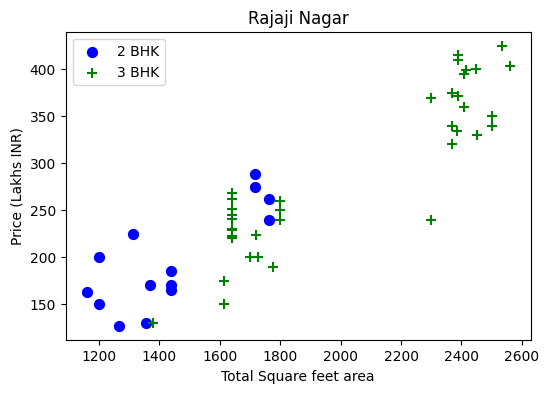

In [ ]:
# For Location : Rajaji Nagar

plot_scatter_chart(df7, 'Rajaji Nagar')

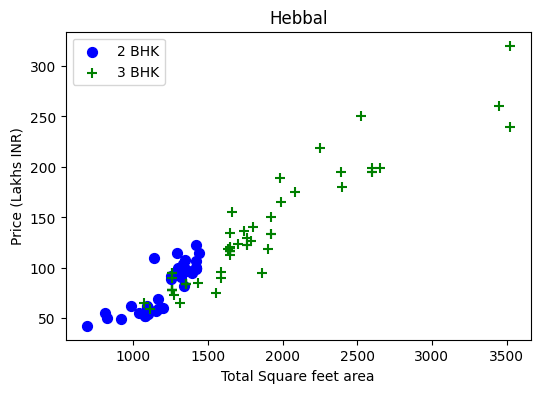

In [ ]:
# For Location : Hebbal

plot_scatter_chart(df7, 'Hebbal')

>We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.


>Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [ ]:
def remove_bhk_outliers(df):
  exclude_indices = np.array([])

  for location, location_df in df.groupby("location"):
    bhk_stats = {}
    for bhk, bhk_df in location_df.groupby("bhk"):
      bhk_stats[bhk] = {
          "mean" : np.mean(bhk_df.price_per_sqft),
          "std" : np.std(bhk_df.price_per_sqft),
          "count" : bhk_df.shape[0]
      }

    for bhk, bhk_df in location_df.groupby("bhk"):
      stats = bhk_stats.get(bhk-1)
      if stats and stats["count"]>5:
        exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats["mean"])].index.values)

  return df.drop(exclude_indices, axis="index")


In [ ]:
df8 = remove_bhk_outliers(df7)
df8.shape

(7331, 7)

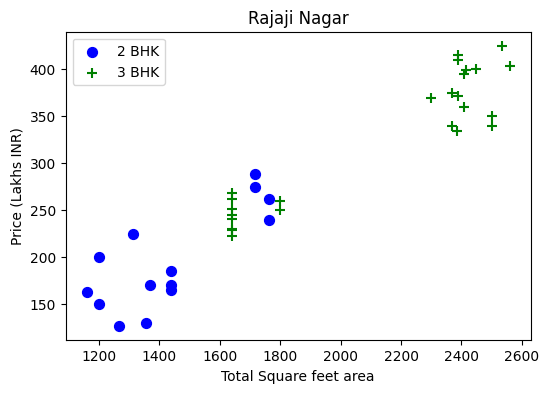

In [ ]:
plot_scatter_chart(df8, "Rajaji Nagar")

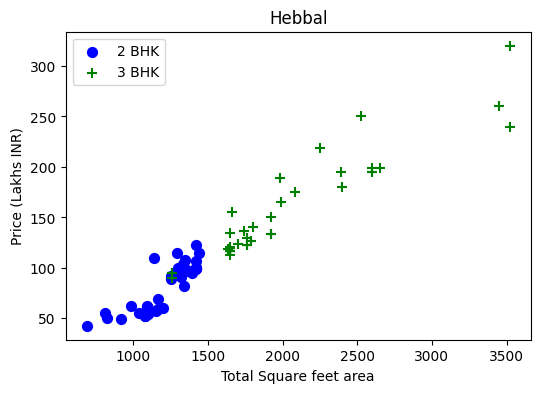

In [ ]:
plot_scatter_chart(df8, "Hebbal")

Text(0, 0.5, 'Count')

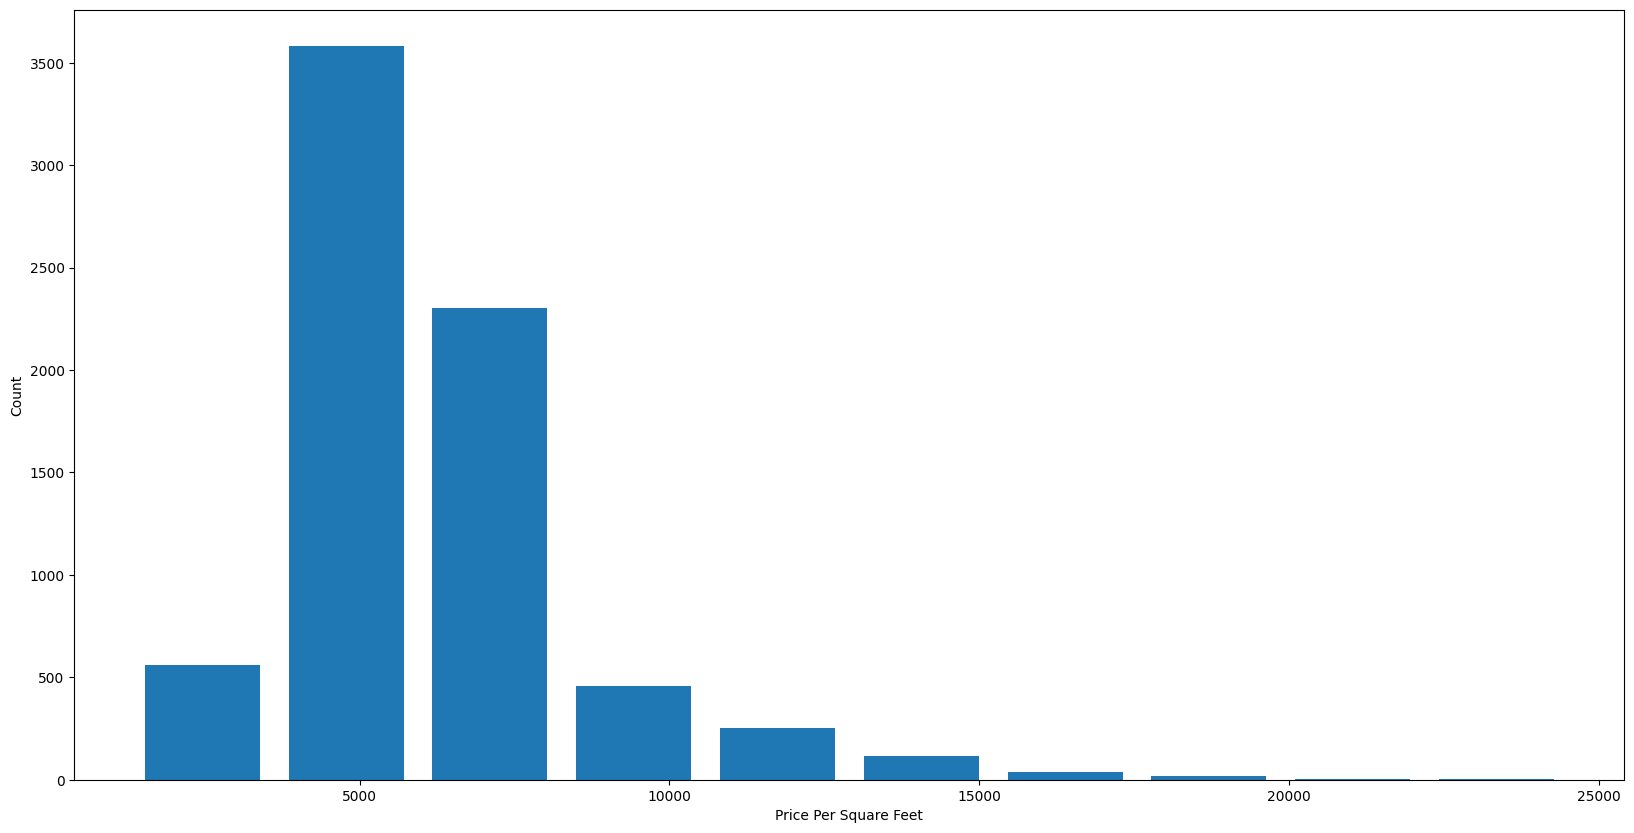

In [ ]:
matplotlib.rcParams["figure.figsize"] = (20, 10)
plt.hist(df8.price_per_sqft, rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [ ]:
df8.bath.unique()

array([ 2.,  3.,  4.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [ ]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5271,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8478,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8567,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9307,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'count')

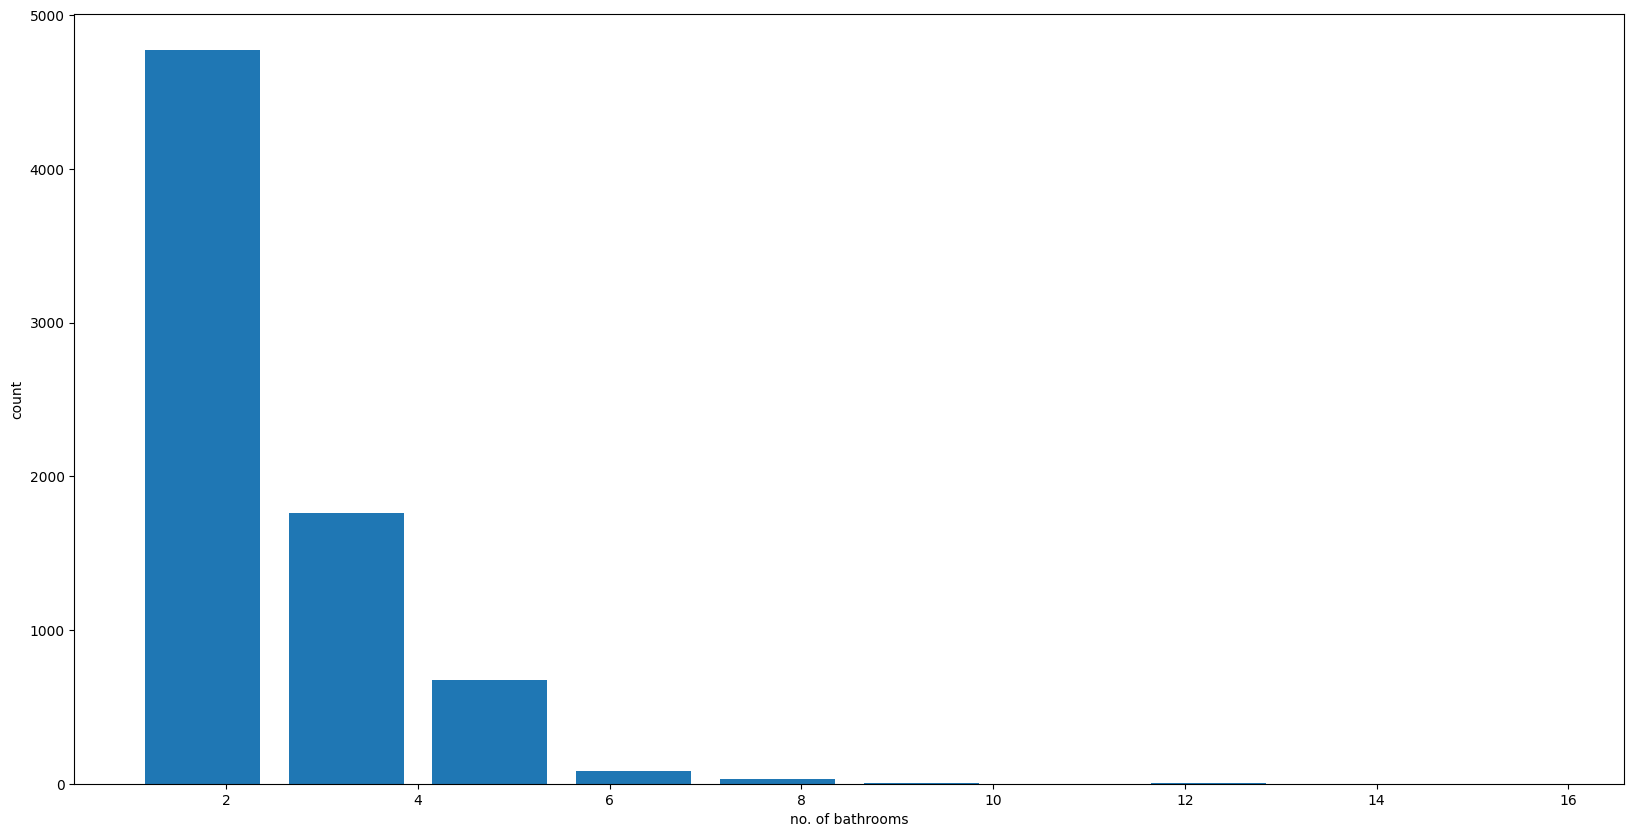

In [ ]:
plt.hist(df8.bath, rwidth=0.8)
plt.xlabel("no. of bathrooms")
plt.ylabel("count")

>it is quite unusal that a home has 2 more bathrooms than the number of bedrooms. 4 bedroom home and even if it has bathroom in all 4 rooms plus one guest bathroom then it'll have total bathrooms = total bed + 1(for guest) max. Anything above that would be consider as an outlier or a data error and should be removed.

In [ ]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1637,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5232,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6702,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8402,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [ ]:
df9 = df8[~(df8.bath>df8.bhk+2)]
df9.shape

(7327, 7)

In [ ]:
df9.columns

Index(['location', 'size', 'total_sqft', 'bath', 'price', 'bhk',
       'price_per_sqft'],
      dtype='object')

In [ ]:
df10 = df9.drop(["price_per_sqft", "size"], axis="columns")
df10.shape

(7327, 5)

In [ ]:
df10.head(10)

,location,total_sqft,bath,price,bhk
1,Devarachikkanahalli,1250.0,2.0,40.0,2
2,Devarachikkanahalli,1200.0,2.0,83.0,2
3,Devarachikkanahalli,1170.0,2.0,40.0,2
4,Devarachikkanahalli,1425.0,2.0,65.0,3
5,Devarachikkanahalli,947.0,2.0,43.0,2
6,Devarachikkanahalli,1130.0,2.0,36.0,2
7,Devarachikkanahalli,1417.0,2.0,76.0,3
8,Devarachikkanahalli,1230.0,2.0,58.0,2
9,Devarachikkanahalli,1705.0,3.0,75.0,3
10,Devarachikkanahalli,1116.0,2.0,47.0,2


### **Use One Hot Encoding For Location**

In [ ]:
dummies = pd.get_dummies(df10.location).astype(int)
dummies.head(10)


,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df11 = pd.concat([df10, dummies.drop("other", axis="columns")], axis="columns")
df11.head()

,location,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,Devarachikkanahalli,1250.0,2.0,40.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Devarachikkanahalli,1200.0,2.0,83.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Devarachikkanahalli,1170.0,2.0,40.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Devarachikkanahalli,1425.0,2.0,65.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Devarachikkanahalli,947.0,2.0,43.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df12 = df11.drop("location", axis="columns")
print(df12.shape)

(7327, 244)


In [ ]:
df12.head(5)

,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,40.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,83.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,40.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1425.0,2.0,65.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,947.0,2.0,43.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df12.describe()

,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
count,7327.000000,7327.000000,7327.000000,7327.000000,7327.000000,7327.000000,7327.000000,7327.000000,7327.000000,7327.000000,...,7327.000000,7327.000000,7327.000000,7327.000000,7327.000000,7327.000000,7327.000000,7327.000000,7327.000000,7327.000000
mean,1490.340008,2.446977,98.541024,2.497748,0.001501,0.000955,0.002184,0.001092,0.000819,0.000819,...,0.004094,0.000546,0.000546,0.004231,0.032756,0.001501,0.011874,0.003276,0.001092,0.005050
std,850.060084,1.008776,92.382471,0.925104,0.038720,0.030896,0.046682,0.033027,0.028606,0.028606,...,0.063861,0.023360,0.023360,0.064912,0.178008,0.038720,0.108326,0.057143,0.033027,0.070887
min,300.000000,1.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1095.000000,2.000000,50.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1257.000000,2.000000,73.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1673.000000,3.000000,112.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30000.000000,16.000000,2200.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### **Building ML models**

In [ ]:
df12.shape

(7327, 244)

In [ ]:
X = df12.drop(['price'],axis='columns')
X.head(10)

,total_sqft,bath,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1425.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,947.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1130.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1417.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1230.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1705.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,1116.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y = df12.price
y.head(3)

,price
1,40.0
2,83.0
3,40.0


In [ ]:
print(X.shape)
print(y.shape)

(7327, 243)
(7327,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [ ]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()

In [ ]:
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.845057284089007

### **Use K Fold cross validation to measure accuracy of our LinearRegression model**

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
np.mean(cross_val_score(LinearRegression(), X, y, cv=cv))

np.float64(0.8354993424725354)

>We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose

### **Find the best model using GridSearchCV**

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(random_state=42),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42)
}

hyperparameters = {
    'Linear Regression': {},  # No hyperparameters to tune
    'Lasso Regression': {
        'alpha': [0.01, 0.1, 1, 10, 50]
    },
    'Decision Tree Regressor': {
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    }
}

In [ ]:
# model training and hyperparameter tuning

best_models = {}

for model_name, model in models.items():
    print(f"Tuning {model_name}...")

    if hyperparameters[model_name]:
        grid = GridSearchCV(
            estimator=model,
            param_grid=hyperparameters[model_name],
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        print(f"Best Parameters for {model_name}: {grid.best_params_}")
        print(f"Best CV RMSE: {np.sqrt(-grid.best_score_):.3f}\n")

    else:
        model.fit(X_train, y_train)
        best_model = model
        print(f"{model_name} trained without tuning.\n")

    best_models[model_name] = best_model

Tuning Linear Regression...
Linear Regression trained without tuning.

Tuning Lasso Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for Lasso Regression: {'alpha': 0.01}
Best CV RMSE: 39.255

Tuning Decision Tree Regressor...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for Decision Tree Regressor: {'max_depth': 10, 'min_samples_split': 5}
Best CV RMSE: 50.267



In [ ]:
best_models

{'Linear Regression': LinearRegression(),
 'Lasso Regression': Lasso(alpha=0.01, random_state=42),
 'Decision Tree Regressor': DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42)}

In [ ]:
# Model Evaluation

results = []

for model_name, model in best_models.items():
    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    #storing results
    results.append({
        'Model': model_name,
        'MAE': round(mae, 3),
        'RMSE': round(rmse, 3),
        'R² Score': round(r2, 3)
    })


Evaluating Linear Regression...
Evaluating Lasso Regression...
Evaluating Decision Tree Regressor...


In [ ]:
# model performance on test set
pd.DataFrame(results)

,Model,MAE,RMSE,R² Score
0,Linear Regression,18.580,34.813,0.845
1,Lasso Regression,18.766,35.747,0.837
2,Decision Tree Regressor,22.019,40.559,0.790


>Based on above results we can say that LinearRegression gives the best score. Hence we will use that.

### Prediction on example_input data {Xq}

In [ ]:
def make_prediction(location, sqft, bath, bhk):
  loc_idx =  np.where(X.columns==location)[0][0]

  Xq = np.zeros(len(X.columns))
  Xq[0] = sqft
  Xq[1] = bath
  Xq[2] = bhk
  if loc_idx >= 0:
    Xq[loc_idx] = 1

  # print(Xq)
  return float(lr_clf.predict([Xq])[0])



In [ ]:
make_prediction('1st Phase JP Nagar', 1000, 2, 2)

86.75907408056833

In [ ]:
make_prediction('1st Phase JP Nagar', 1000, 3, 3)

89.22786912029632

In [ ]:
make_prediction('Indira Nagar', 1000, 2, 2)

189.09695669091502

### **Save Best Model**

In [ ]:
import pickle

with open('best_model.pickle', 'wb') as f:
  pickle.dump(lr_clf, f)

Exporting location and column info to a json file that will be use later to build web application

In [ ]:
import json

cols = {
    'data_cols' : [col.lower() for col in X.columns]
}


with open("columns.json", "w") as f:
  f.write(json.dumps(cols))